In [4]:
#importing all require python libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR  #SVR regression for crop yield forecasting or prediction
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM  #class for LSTM regression
from keras.layers import Dropout
from keras.models import model_from_json
import pickle
import os
from keras.callbacks import ModelCheckpoint
from keras.layers import  MaxPooling2D
from keras.layers import Flatten
from keras.layers import Convolution2D #CNN regression
from sklearn.neural_network import MLPRegressor #DNN regression 
from sklearn.metrics import r2_score

In [5]:
#class to normalize dataset values
sc = MinMaxScaler(feature_range = (0, 1))

In [6]:
#defining global variables
rsquare = []
mse = []

In [7]:
#function for crop Yield Prediction
def prediction(algorithm, y_test, predict):
    #calculating MSE error
    mse_error = mean_squared_error(y_test, predict)
    square_error = r2_score(y_test, predict) #calculate rsquare between true test crop yield and predicted yield
    rsquare.append(square_error)
    mse.append(mse_error)
    predict = predict.reshape(predict.shape[0],1)
    predict = sc.inverse_transform(predict)
    predict = predict.ravel()
    labels = sc.inverse_transform(y_test)
    labels = labels.ravel()
    print()
    print(algorithm+" MSE : "+str(mse_error))
    print(algorithm+" R2 : "+str(square_error))
    print()
    for i in range(0,10):
        print("Test Crop Yield : "+str(labels[i])+" Predicted Crop Yield : "+str(predict[i]))
    #plotting comparison graph between original values and predicted values
    plt.plot(labels, color = 'red', label = 'Test Crop Yield')
    plt.plot(predict, color = 'green', label = 'Predicted Crop Yield')
    plt.title(algorithm+" Crop Yield Prediction Graph")
    plt.xlabel('Test Crop Data')
    plt.ylabel('Crop Yield Prediction')
    plt.legend()
    plt.show()

In [8]:
#function to load and preprocess maize or potato dataset
def readProcessDataset(dataset_file):
    dataset = pd.read_csv(dataset_file)#read dataset
    dataset.fillna(0, inplace = True)#remove missing values
    dataset
    temp = dataset.values
    Y = temp[:,4:5] #get target crop yield values from the dataset
    dataset.drop(['hg/ha_yield'], axis = 1,inplace=True)
    dataset.drop(['index', 'Area', 'Item'], axis = 1,inplace=True)#remove irrelevant fetaures
    dataset = dataset.values
    X = dataset[:,0:dataset.shape[1]]#get feature from the dataset
    X = sc.fit_transform(X)#normalize the dataset values
    Y = sc.fit_transform(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)#split data into train and test
    print()
    print("Dataset Size : "+str(X.shape[0]))
    print("80% dataset size used for training : "+str(X_train.shape[0]))
    print("20% dataset size used for testing  : "+str(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [9]:
#call this function either with Maize.csv to predict maize yield or change to Potato.csv to predict potato yield
X_train, X_test, y_train, y_test = readProcessDataset("Dataset/Maize.csv")


Dataset Size : 506
80% dataset size used for training : 404
20% dataset size used for testing  : 102



SVR MSE : 0.010237655143040196
SVR R2 : 0.884002789580553

Test Crop Yield : 19385.0 Predicted Crop Yield : 19922.13823095935
Test Crop Yield : 23352.0 Predicted Crop Yield : 20959.03084550411
Test Crop Yield : 17922.0 Predicted Crop Yield : 17054.22285368542
Test Crop Yield : 20238.0 Predicted Crop Yield : 22371.48494716911
Test Crop Yield : 16015.0 Predicted Crop Yield : 15488.332783051117
Test Crop Yield : 15178.000000000002 Predicted Crop Yield : 14750.965354379447
Test Crop Yield : 25726.0 Predicted Crop Yield : 26305.467240409296
Test Crop Yield : 19125.0 Predicted Crop Yield : 20546.366021407142
Test Crop Yield : 19385.0 Predicted Crop Yield : 19929.81068682725
Test Crop Yield : 14480.0 Predicted Crop Yield : 15675.857299043264


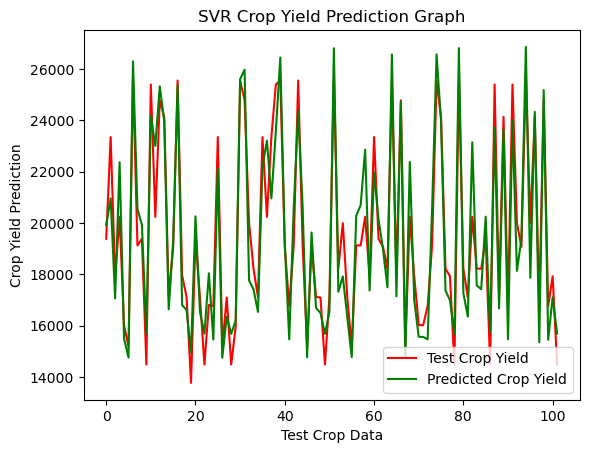

In [10]:
#now train and plot SVR crop yield prediction graph
svr_regression = SVR()
#training SVR with X and Y data
svr_regression.fit(X_train, y_train.ravel())
#performing prediction on test data
predict = svr_regression.predict(X_test)
prediction("SVR", y_test, predict)

In [11]:
#now train & plot LSTM crop yield prediction graph
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential()#defing object
#adding LSTM layer with 50 neurons to filter dataset 50 time
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train1.shape[1], X_train1.shape[2])))
#dropoout layer to remove irrelevant features from dataset
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1)) #defining output crop yield prediction layer
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#now train, load the model for crop yield prediction
if os.path.exists("model/lstm_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/lstm_weights.hdf5', verbose = 1, save_best_only = True)
    lstm_model.fit(X_train1, y_train, batch_size = 16, epochs = 1000, validation_data=(X_test1, y_test), callbacks=[model_check_point], verbose=1)    
else:
    lstm_model.load_weights("model/lstm_weights.hdf5")
predict = lstm_model.predict(X_test1)
prediction("LSTM", y_test, predict)#call function to plot LSTM prediction graph

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step

LSTM MSE : 0.16691296187747584
LSTM R2 : -0.8911984912675119

Test Crop Yield : 19385.0 Predicted Crop Yield : 15433.459
Test Crop Yield : 23352.0 Predicted Crop Yield : 15151.843
Test Crop Yield : 17922.0 Predicted Crop Yield : 16256.603
Test Crop Yield : 20238.0 Predicted Crop Yield : 15941.189
Test Crop Yield : 16015.0 Predicted Crop Yield : 14555.959
Test Crop Yield : 15178.000000000002 Predicted Crop Yield : 14458.601
Test Crop Yield : 25726.0 Predicted Crop Yield : 17203.068
Test Crop Yield : 19125.0 Predicted Crop Yield : 15307.168
Test Crop Yield : 19385.0 Predicted Crop Yield : 15433.363
Test Crop Yield : 14480.0 Predicted Crop Yield : 14627.913


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

ANN MSE : 0.15928210798077966
ANN R2 : -0.8047375045700964

Test Crop Yield : 19385.0 Predicted Crop Yield : 15015.256
Test Crop Yield : 23352.0 Predicted Crop Yield : 15559.232
Test Crop Yield : 17922.0 Predicted Crop Yield : 15603.336
Test Crop Yield : 20238.0 Predicted Crop Yield : 15747.857
Test Crop Yield : 16015.0 Predicted Crop Yield : 14869.986
Test Crop Yield : 15178.000000000002 Predicted Crop Yield : 14516.904
Test Crop Yield : 25726.0 Predicted Crop Yield : 17561.508
Test Crop Yield : 19125.0 Predicted Crop Yield : 15230.059
Test Crop Yield : 19385.0 Predicted Crop Yield : 15023.482
Test Crop Yield : 14480.0 Predicted Crop Yield : 14871.476


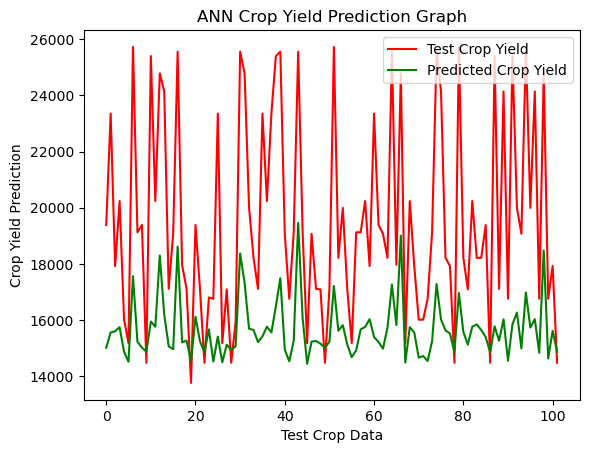

In [12]:
#now train & plot ANN crop yield prediction graph
ann_model = Sequential()
#adding ANN dense layer with 50 neurons to filter dataset 50 time
ann_model.add(Dense(50, input_shape=(X_train.shape[1],)))
ann_model.add(Activation('relu'))
#dropoout layer to remove irrelevant features from dataset
ann_model.add(Dropout(0.2))
ann_model.add(Dense(50))
ann_model.add(Activation('relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(1)) #defining output crop yield prediction layer
ann_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#now train, load the model for crop yield prediction
if os.path.exists("model/ann_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/ann_weights.hdf5', verbose = 1, save_best_only = True)
    ann_model.fit(X_train, y_train, batch_size = 16, epochs = 1000, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)    
else:
    ann_model.load_weights("model/ann_weights.hdf5")
predict = ann_model.predict(X_test)
prediction("ANN", y_test, predict)#call function to plot ANN prediction graph

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B850D919E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

CNN MSE : 0.1425836678646162
CNN R2 : -0.6155367115400687

Test Crop Yield : 19385.0 Predicted Crop Yield : 15642.107
Test Crop Yield : 23352.0 Predicted Crop Yield : 15483.781
Test Crop Yield : 1

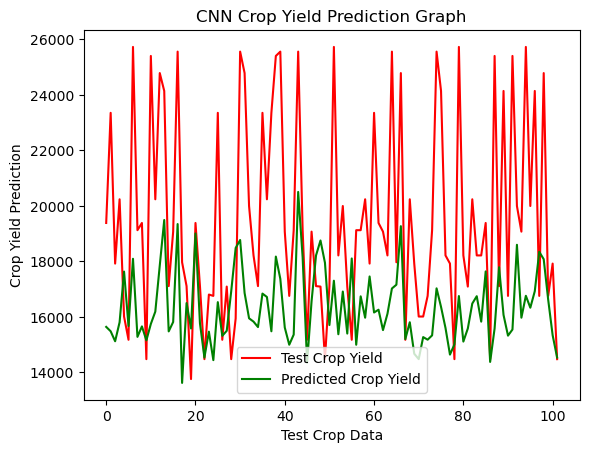

In [13]:
#now train & plot CNN crop yield prediction graph
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
#define CNN object
cnn_model = Sequential()
#add CNN convolution neural network layer with 32 neurons of dimension 1 X 1 to filetr dataset 32 times
cnn_model.add(Convolution2D(32, (1, 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1))) #max pool layer to collect filtered features from CNN layer
cnn_model.add(Convolution2D(32, (1, 1), activation = 'relu'))#adding another layer for filtration
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
cnn_model.add(Flatten()) #convert multidimension data to single dimension data
cnn_model.add(Dense(units = 256)) #defining output layer
cnn_model.add(Dense(units = 1)) #defining prediction layer of 1 as crop yield prediction
cnn_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#now train, load the model for crop yield prediction
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    cnn_model.fit(X_train1, y_train, batch_size = 16, epochs = 1000, validation_data=(X_test1, y_test), callbacks=[model_check_point], verbose=1)    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
predict = cnn_model.predict(X_test1)
prediction("CNN", y_test, predict)#call function to plot CNN prediction graph


DNN MSE : 0.014204603717315465
DNN R2 : 0.8390554884589521

Test Crop Yield : 19385.0 Predicted Crop Yield : 20941.164232852752
Test Crop Yield : 23352.0 Predicted Crop Yield : 21679.508208230713
Test Crop Yield : 17922.0 Predicted Crop Yield : 18088.657970470675
Test Crop Yield : 20238.0 Predicted Crop Yield : 22592.198307164464
Test Crop Yield : 16015.0 Predicted Crop Yield : 15380.045109243125
Test Crop Yield : 15178.000000000002 Predicted Crop Yield : 14046.286159475974
Test Crop Yield : 25726.0 Predicted Crop Yield : 24807.99107046515
Test Crop Yield : 19125.0 Predicted Crop Yield : 21392.898082856853
Test Crop Yield : 19385.0 Predicted Crop Yield : 20945.152105439993
Test Crop Yield : 14480.0 Predicted Crop Yield : 15764.499250312558


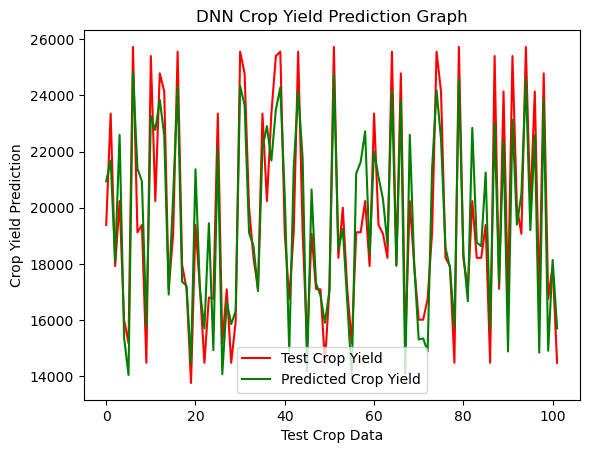

In [14]:
#now train & plot DNN crop yield prediction graph
dnn = MLPRegressor()
#training DNN with Xtrain and Ytrain data
dnn.fit(X_train, y_train.ravel())
#performing prediction on test data
predict = dnn.predict(X_test)
prediction("DNN", y_test, predict)#call function to plot LSTM prediction graph

In [15]:
print(len(mse))
print(len(rsquare))


5
5


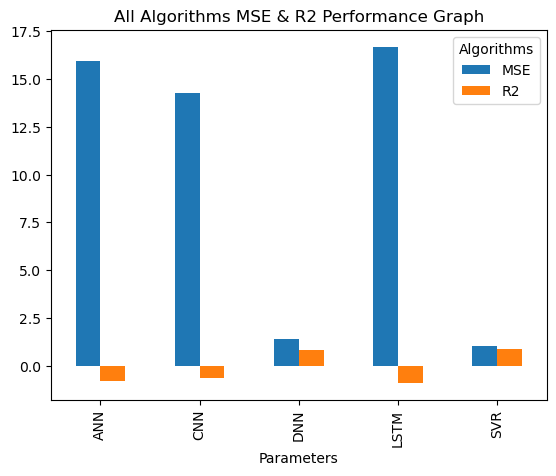

In [16]:
# Check lengths of mse and rsquare
if len(mse) < 5 or len(rsquare) < 5:
    print("Error: The mse and rsquare lists do not contain enough elements.")
else:
    df = pd.DataFrame([['SVR', 'MSE', mse[0]*100], ['SVR', 'R2', rsquare[0]],
                       ['LSTM', 'MSE', mse[1]*100], ['LSTM', 'R2', rsquare[1]],
                       ['ANN', 'MSE', mse[2]*100], ['ANN', 'R2', rsquare[2]],
                       ['CNN', 'MSE', mse[3]*100], ['CNN', 'R2', rsquare[3]],
                       ['DNN', 'MSE', mse[4]*100], ['DNN', 'R2', rsquare[4]]],
                      columns=['Parameters', 'Algorithms', 'Value'])

    df.pivot(index='Parameters', columns='Algorithms', values='Value').plot(kind='bar')
    plt.title("All Algorithms MSE & R2 Performance Graph")
    plt.show()



Min Rainfall    : 541.5
Median Rainfall : 1083.0
Max Rainfall    : 1083.0



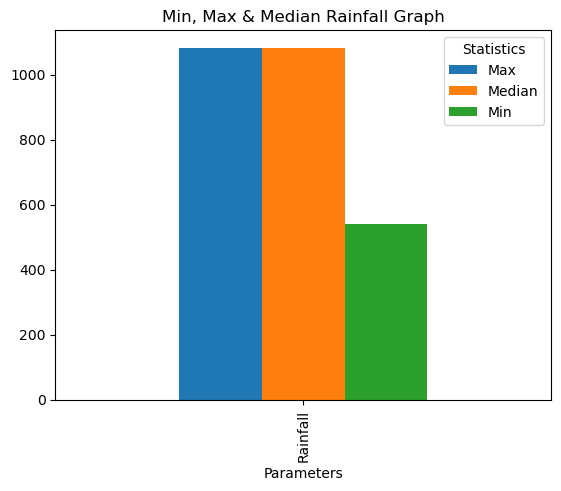

In [17]:
dataset = pd.read_csv("Dataset/Maize.csv")
rainfall = dataset['average_rain_fall_mm_per_year']
min_rainfall = np.min(rainfall) / 2
max_rainfall = np.max(rainfall)
median_rainfall = np.median(rainfall)
print()
print("Min Rainfall    : "+str(min_rainfall))
print("Median Rainfall : "+str(median_rainfall))
print("Max Rainfall    : "+str(max_rainfall))
print()
# Create a DataFrame with the rainfall data
df = pd.DataFrame([
    ['Rainfall', 'Min', min_rainfall],
    ['Rainfall', 'Median', median_rainfall],
    ['Rainfall', 'Max', max_rainfall]
], columns=['Parameters', 'Statistics', 'Value'])

# Pivot the DataFrame and plot
df_pivot = df.pivot(index='Parameters', columns='Statistics', values='Value')
df_pivot.plot(kind='bar')

# Customize and display the plot
plt.title("Min, Max & Median Rainfall Graph")
plt.show()
